# MMOCR Tutorial

Welcome to MMOCR! This is the official colab tutorial for using MMOCR. In this tutorial, you will learn how to

- Install MMOCR from source
- Perform inference with
  - a pretrained text recognizer
  - a pretrained text detector
  - pretrained recognizer and detector
  - pretrained Key Information Extraction (KIE) model
- Evaluate a text detection model on an acadmic dataset
- Train a text recognizer with a toy dataset

Let's start!

## Install MMOCR from source

Installing MMOCR is straightforward. We recommend users to install MMOCR from source as any local code changes on MMOCR can take effect immediately, which is needed for research & developement purpose. Refer to [documentation](https://mmocr.readthedocs.io/en/dev-1.x/get_started/install.html) for more information.

### Install Dependencies using MIM

In [ ]:
# !pip install -U openmim
# !mim install mmengine
# !mim install 'mmcv>=2.0.0rc1'
# !mim install 'mmdet>=3.0.0rc0'

### Install MMOCR

In [ ]:
# !git clone https://github.com/open-mmlab/mmocr.git
# %cd mmocr
# !pip install -v -e .
# # "-v" increases pip's verbosity.
# # "-e" means installing the project in editable mode,
# # That is, any local modifications on the code will take effect immediately.

## Inference

MMOCR has made inference easy by providing a variety of `Inferencer`s. In this section, we will focus on the usage of `MMOCRInferencer`. However, if you want to learn more about other `Inferencer`s, you can refer to the [documentation](https://mmocr.readthedocs.io/en/dev-1.x/user_guides/inference.html) which provides detailed descriptions.

### Perform Inference with a Pretrained Text Recognizer 

We now demonstrate how to inference on a demo text recognition image with a pretrained text recognizer. SVTR text recognizer is used for this demo, whose checkpoint can be found in the [official documentation](https://mmocr.readthedocs.io/en/dev-1.x/textrecog_models.html#svtr). But you don't need to download it manually -- Our Inferencer script handles these cumbersome setup steps for you! 

Run the following command and you will get the inference result from return value as well as files, which will be  visualized in the end.

In [18]:
# As function

import mlflow
from pathlib import Path
from glob import glob

# TEXTRECOG_MODEL_NAME = "ABINet"
# TEXTRECOG_MODEL_VERSION = "1"

TEXTRECOG_MODEL_NAME = "SATRN"
TEXTRECOG_MODEL_VERSION = "1"

def load_model_ckpt(name, version, file_regex="*"):
    ckpt_root = Path("ckpt/mmocr/")
    model_path = ckpt_root / name / version
    model_path.mkdir(parents=True, exist_ok=True)
    
    model_uri = f"models:/{name}/{version}"
    _ = mlflow.pytorch.load_model(model_uri, dst_path=model_path)
    
    ckpt_paths = glob(f'{model_path}/extra_files/{file_regex}')
    assert len(ckpt_paths) == 1, f"Expected 1 checkpoint file, got {len(ckpt_paths)}"
    
    return ckpt_paths[0]

textrecog_ckpt_path = load_model_ckpt(TEXTRECOG_MODEL_NAME, TEXTRECOG_MODEL_VERSION)

In [19]:
from mlflow.tracking import MlflowClient

def download_config(model_name, model_version):
    client = MlflowClient()
    mv = client.get_model_version(name=model_name, version=model_version)
    run_id = mv.run_id
    
    config_path = mlflow.artifacts.download_artifacts(
        run_id=run_id,
        artifact_path="config.py", 
        dst_path=f"./ckpt/mmocr/{model_name}/{model_version}"
    )
    return config_path

textrecog_config_path = download_config(TEXTRECOG_MODEL_NAME, TEXTRECOG_MODEL_VERSION)

In [22]:
%%capture

import os
from mmocr.apis import MMOCRInferencer
from tqdm import tqdm

# NUM_IMGS = 1
NUM_IMGS = None

DEMO_RECOG_IMG_DIR = 'data/HF_dataset/samples/ear-tags/recognition'

infer = MMOCRInferencer(
    rec = TEXTRECOG_MODEL_NAME,
    rec_weights=textrecog_ckpt_path,
)

# Collect only the visualisation images
results = []
for fname in tqdm(os.listdir(DEMO_RECOG_IMG_DIR)[:NUM_IMGS]):
    out = infer(os.path.join(DEMO_RECOG_IMG_DIR, fname), return_vis=True)
    vis_bgr = out['visualization'][0]      # ndarray, BGR
    vis_rgb = vis_bgr[..., ::-1]           # convert to RGB for matplotlib
    results.append(vis_rgb)

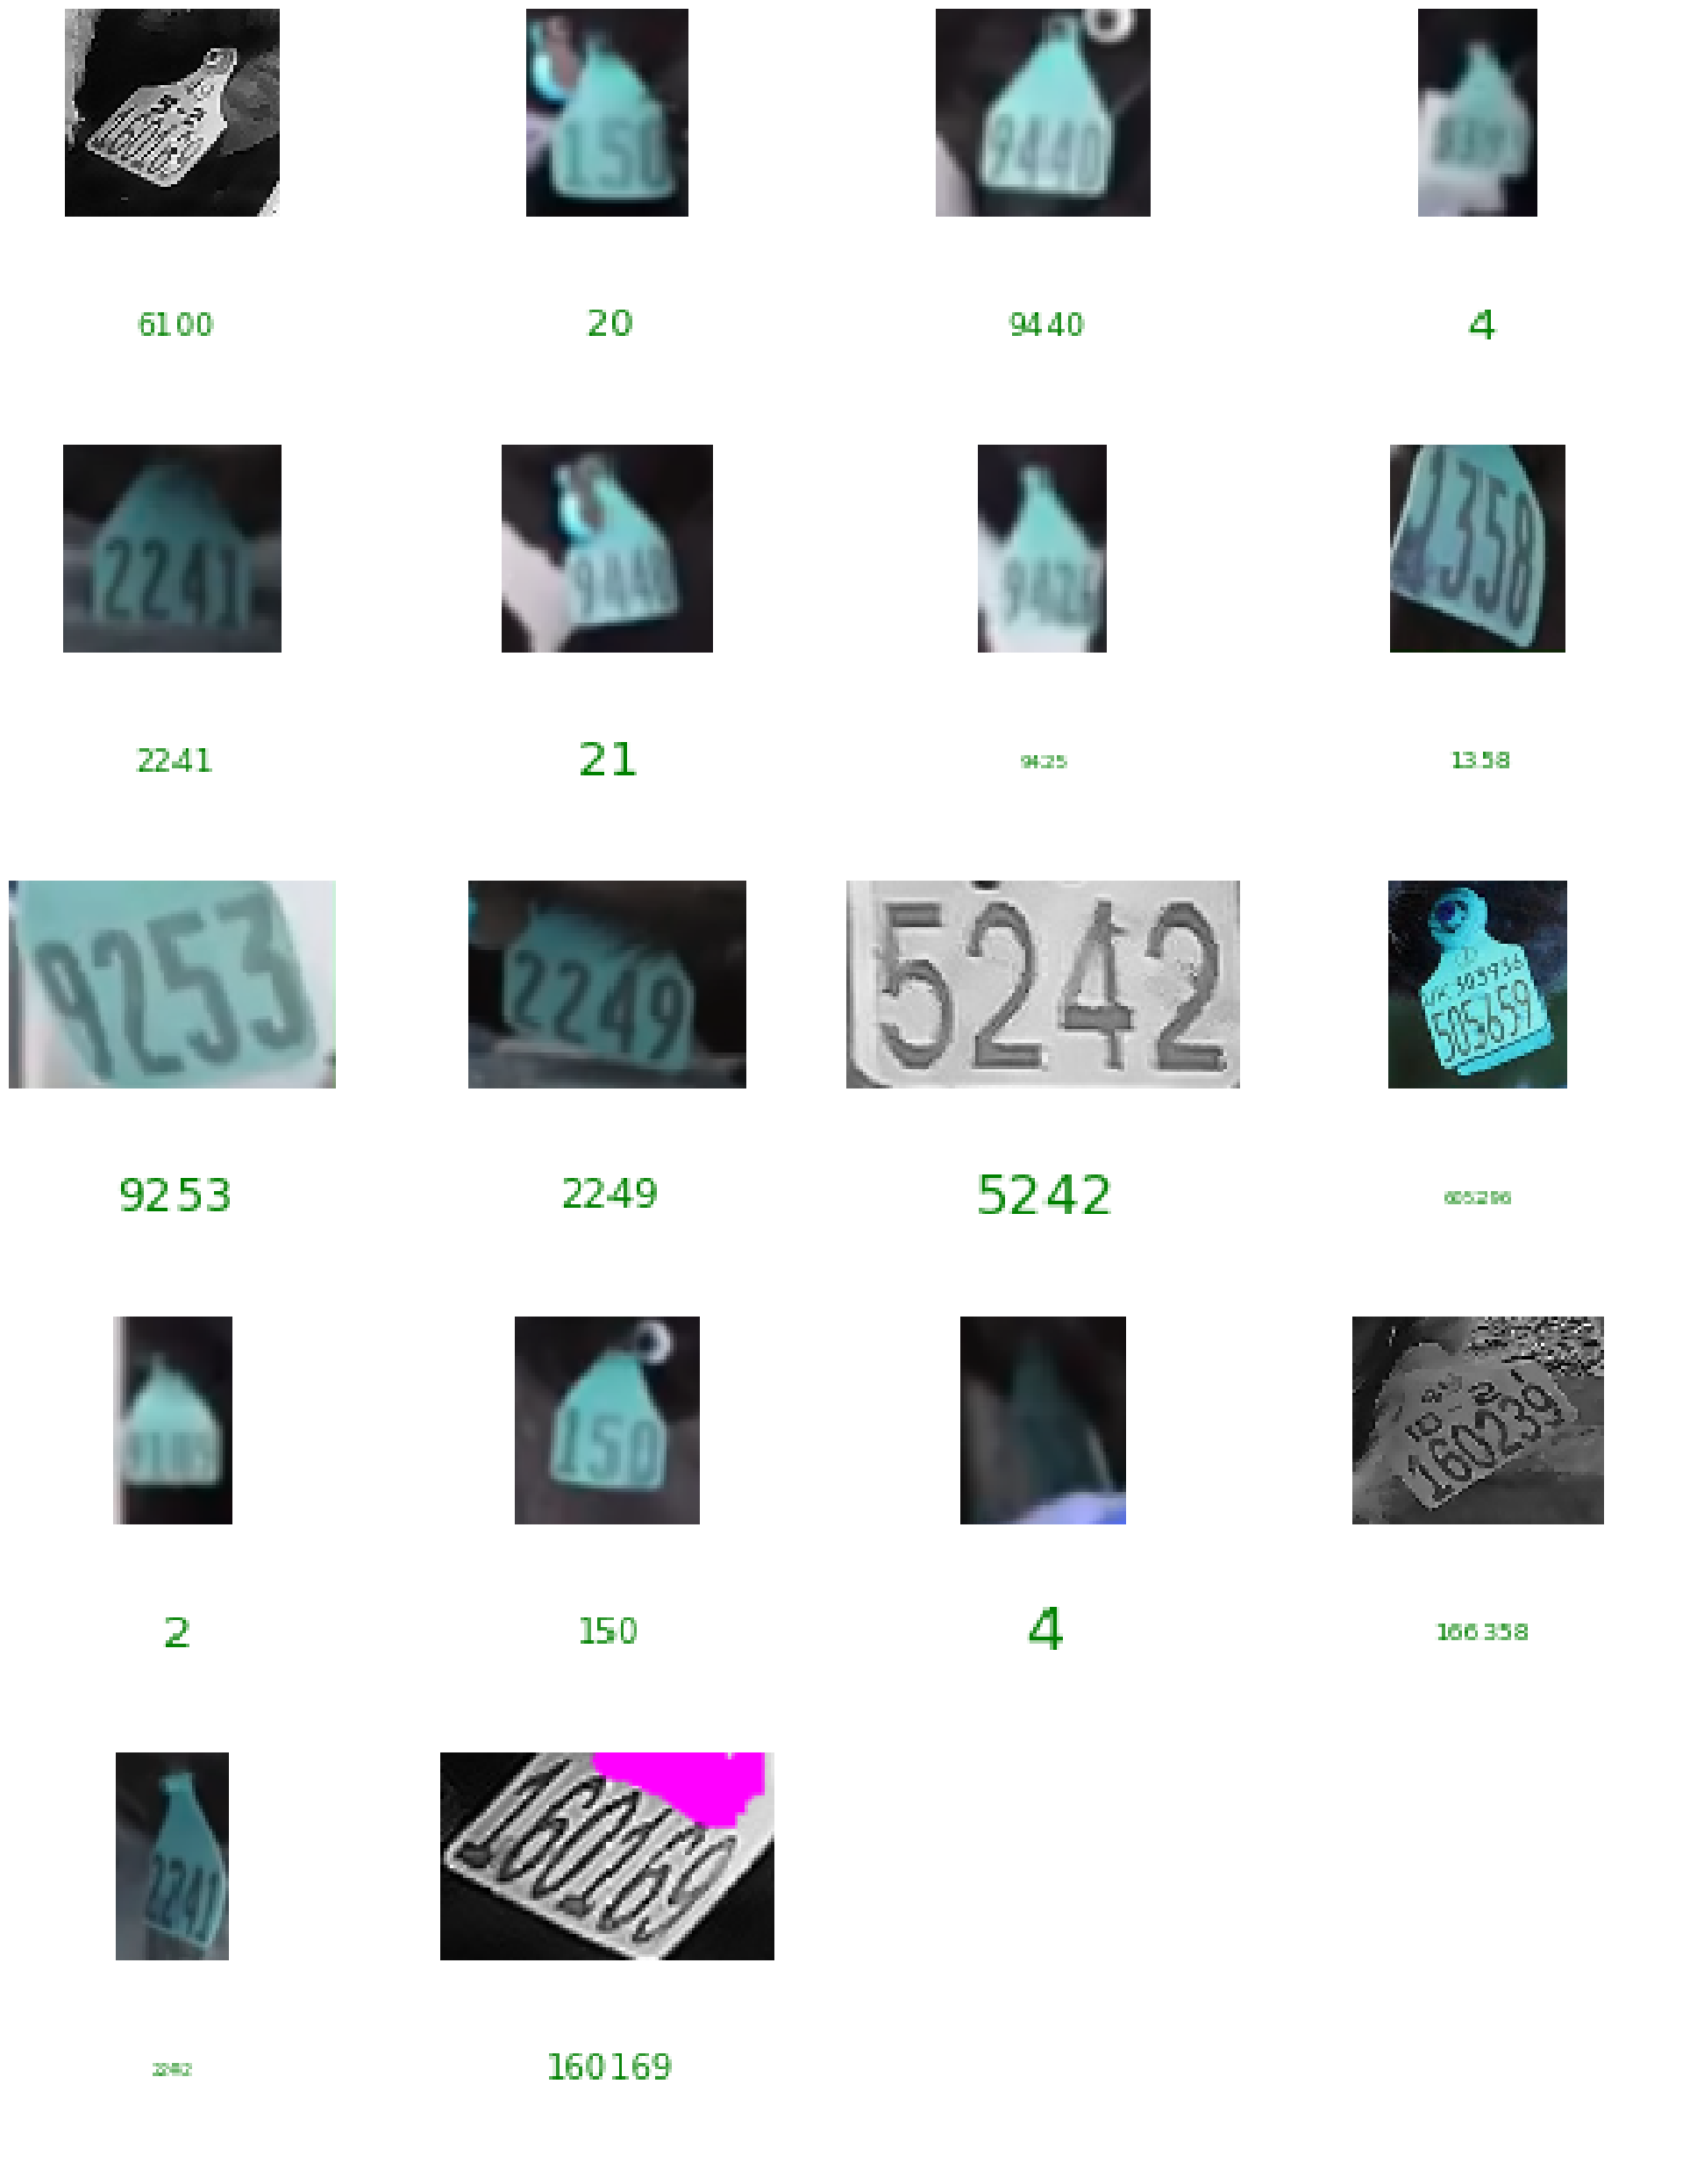

In [23]:
import math
import matplotlib.pyplot as plt

PLOT_COLS = 4

# Plot in grid
PLOT_ROWS = math.ceil(len(results) / PLOT_COLS)
fig, axes = plt.subplots(PLOT_ROWS, PLOT_COLS, figsize=(20, 5*PLOT_ROWS))
axes = axes.ravel()

for idx, img in enumerate(results):
    axes[idx].imshow(img)
    axes[idx].axis('off')

# Hide empty subplots
for idx in range(len(results), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Perform Inference with a Pretrained Text Detector 

Next, we perform inference with a pretrained DBNet++ text detector and visualize the bounding box results for the demo text detection image.

In [24]:
# As function

import mlflow
from pathlib import Path
from glob import glob

TEXTDET_MODEL_NAME = "DBNet"
TEXTDET_MODEL_VERSION = "1"

# TEXTDET_MODEL_NAME = "PANet"
# TEXTDET_MODEL_VERSION = "1"

def load_model_ckpt(name, version, file_regex="*"):
    ckpt_root = Path("ckpt/mmocr/")
    model_path = ckpt_root / name / version
    model_path.mkdir(parents=True, exist_ok=True)
    
    model_uri = f"models:/{name}/{version}"
    _ = mlflow.pytorch.load_model(model_uri, dst_path=model_path)
    
    ckpt_paths = glob(f'{model_path}/extra_files/{file_regex}')
    assert len(ckpt_paths) == 1, f"Expected 1 checkpoint file, got {len(ckpt_paths)}"
    
    return ckpt_paths[0]

textdet_ckpt_path = load_model_ckpt(TEXTDET_MODEL_NAME, TEXTDET_MODEL_VERSION)

In [25]:
from mlflow.tracking import MlflowClient

def download_config(model_name, model_version):
    client = MlflowClient()
    mv = client.get_model_version(name=model_name, version=model_version)
    run_id = mv.run_id
    
    config_path = mlflow.artifacts.download_artifacts(
        run_id=run_id,
        artifact_path="config.py", 
        dst_path=f"./ckpt/mmocr/{model_name}/{model_version}"
    )
    return config_path

textdet_config_path = download_config(TEXTDET_MODEL_NAME, TEXTDET_MODEL_VERSION)

In [28]:
# %%capture

from tqdm import tqdm
from mmocr.apis import MMOCRInferencer
from mmocr.apis import MMOCRInferencer
import os
from mmengine import Config

# NUM_IMGS = 1
NUM_IMGS = None

DEMO_DET_IMG_DIR = 'data/HF_dataset/samples/ear-tags/recognition'

infer = MMOCRInferencer(
    det=Config.fromfile(textdet_config_path),
    det_weights=textdet_ckpt_path,
)

# Get all images first
results = []
for test_img_path in tqdm(os.listdir(DEMO_DET_IMG_DIR)[:NUM_IMGS]):
    result = infer(os.path.join(DEMO_DET_IMG_DIR, test_img_path), return_vis=True)
    results.append(result['visualization'][0])

Loads checkpoint by local backend from path: ckpt/mmocr/DBNet/1/extra_files/epoch_7.pth
07/31 17:21:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
07/31 17:21:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
07/31 17:21:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
07/31 17:21:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
07/31 17:21:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
07/31 17:21:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
07/31 17:21:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
07/31 17:21:38 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
07/31 17:21:38 - mmengine - INFO - Modul

  0%|          | 0/18 [00:00<?, ?it/s]

Output()

Output()

 11%|█         | 2/18 [00:00<00:00, 18.39it/s]

Output()

Output()

 22%|██▏       | 4/18 [00:00<00:00, 17.64it/s]

Output()

Output()

 33%|███▎      | 6/18 [00:00<00:00, 17.91it/s]

Output()

Output()

/home/bonting/micromamba/envs/bonting-id/lib/python3.11/site-packages/mmengine/visualization/visualizer.py:831: 
UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(

 44%|████▍     | 8/18 [00:00<00:00, 15.35it/s]

Output()

Output()

 56%|█████▌    | 10/18 [00:00<00:00, 13.31it/s]

Output()

Output()

 67%|██████▋   | 12/18 [00:00<00:00, 11.09it/s]

Output()

Output()

 78%|███████▊  | 14/18 [00:01<00:00, 12.46it/s]

Output()

Output()

 89%|████████▉ | 16/18 [00:01<00:00, 13.64it/s]

Output()

Output()

100%|██████████| 18/18 [00:01<00:00, 13.60it/s]


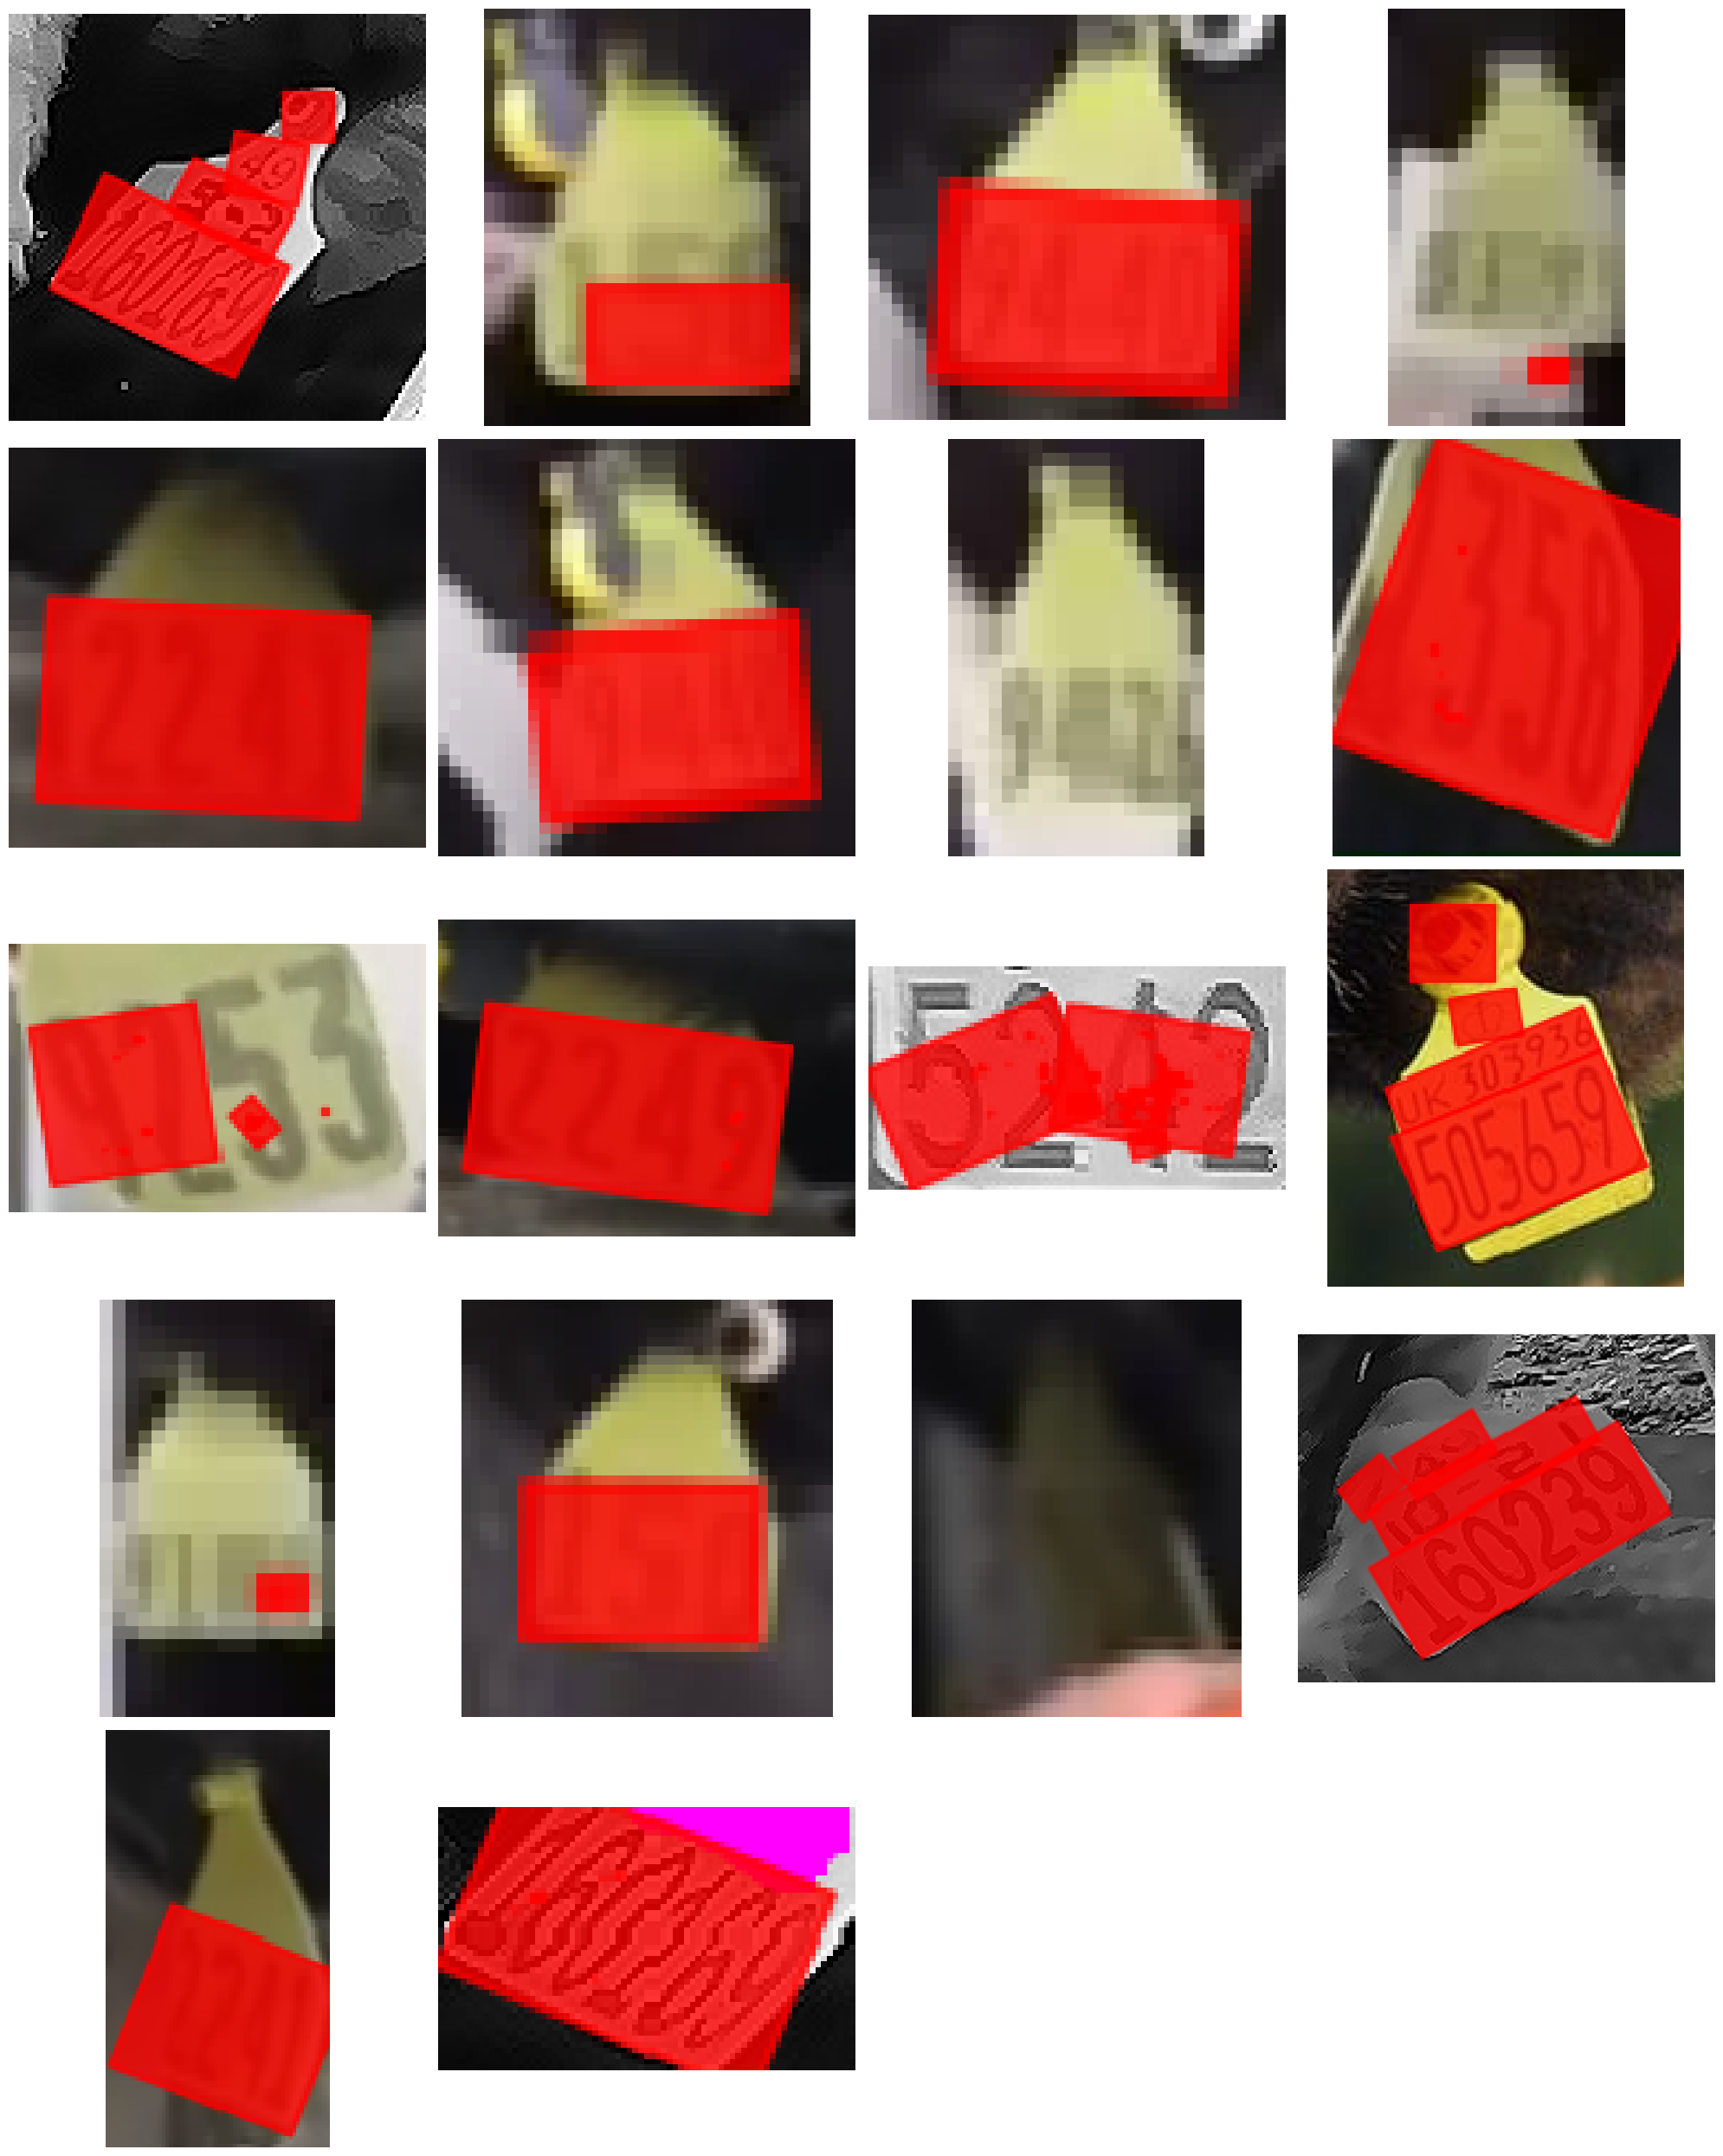

In [29]:
import math
import matplotlib.pyplot as plt

PLOT_COLS = 4

# Plot in grid
PLOT_ROWS = math.ceil(len(results) / PLOT_COLS)
fig, axes = plt.subplots(PLOT_ROWS, PLOT_COLS, figsize=(20, 5*PLOT_ROWS))
axes = axes.ravel()

for idx, img in enumerate(results):
    axes[idx].imshow(img)
    axes[idx].axis('off')

# Hide empty subplots
for idx in range(len(results), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Perform end-to-end OCR with pretrained recognizer and detector

We can  any text detector and recognizer into a pipeline that forms a standard OCR pipeline. Now we build our own OCR pipeline with DBNet++ and SVTR and apply it to `demo/demo_text_ocr.jpg`.

In [30]:
import os
from mmocr.apis import MMOCRInferencer

infer = MMOCRInferencer(
    # rec="ABINet",
    # rec_weights='ckpt/mmocr/ABINet/1/extra_files/best_test_word_acc_epoch_1.pth',
    # det='configs/textdet/dbnet_custom/dbnet_cegdr.py',
    # det_weights='ckpt/mmocr/DBNet/1/extra_files/best_test_hmean',

    det=Config.fromfile(textdet_config_path),
    det_weights=textdet_ckpt_path,
    rec=TEXTRECOG_MODEL_NAME,
    rec_weights=textrecog_ckpt_path,
)

DEMO_E2EOCR_IMG_DIR = 'data/HF_dataset/samples/ear-tags/recognition'

Loads checkpoint by local backend from path: ckpt/mmocr/DBNet/1/extra_files/epoch_7.pth
07/31 17:22:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
07/31 17:22:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
07/31 17:22:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
07/31 17:22:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
07/31 17:22:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
07/31 17:22:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
07/31 17:22:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
07/31 17:22:23 - mmengine - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
07/31 17:22:23 - mmengine - INFO - Modul

In [31]:
# %%capture

from tqdm import tqdm
import os

# N_IMGS = 2
N_IMGS = None

# Collect high-level OCR results only
ocr_results = []

for test_img_path in tqdm(os.listdir(DEMO_E2EOCR_IMG_DIR)[:N_IMGS]):
    result = infer(os.path.join(DEMO_E2EOCR_IMG_DIR, test_img_path), return_vis=True)
    ocr_results.append(result)

  0%|          | 0/18 [00:00<?, ?it/s]

Output()

  6%|▌         | 1/18 [00:00<00:05,  3.33it/s]

Output()

 11%|█         | 2/18 [00:00<00:04,  3.90it/s]

Output()

 17%|█▋        | 3/18 [00:00<00:02,  5.31it/s]

Output()

 22%|██▏       | 4/18 [00:01<00:04,  3.44it/s]

Output()

 28%|██▊       | 5/18 [00:01<00:03,  4.18it/s]

Output()

Output()

 39%|███▉      | 7/18 [00:01<00:01,  6.62it/s]

Output()

 44%|████▍     | 8/18 [00:02<00:03,  3.04it/s]

Output()

 50%|█████     | 9/18 [00:04<00:07,  1.13it/s]

Output()

 56%|█████▌    | 10/18 [00:05<00:06,  1.26it/s]

Output()

 61%|██████    | 11/18 [00:24<00:42,  6.13s/it]

Output()

 67%|██████▋   | 12/18 [00:24<00:26,  4.42s/it]

Output()

 72%|███████▏  | 13/18 [00:25<00:16,  3.21s/it]

Output()

 78%|███████▊  | 14/18 [00:25<00:09,  2.33s/it]

Output()

Output()

 89%|████████▉ | 16/18 [00:25<00:02,  1.33s/it]

Output()

 94%|█████████▍| 17/18 [00:25<00:01,  1.05s/it]

Output()

100%|██████████| 18/18 [00:26<00:00,  1.48s/it]


/tmp/ipykernel_579120/3399827708.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


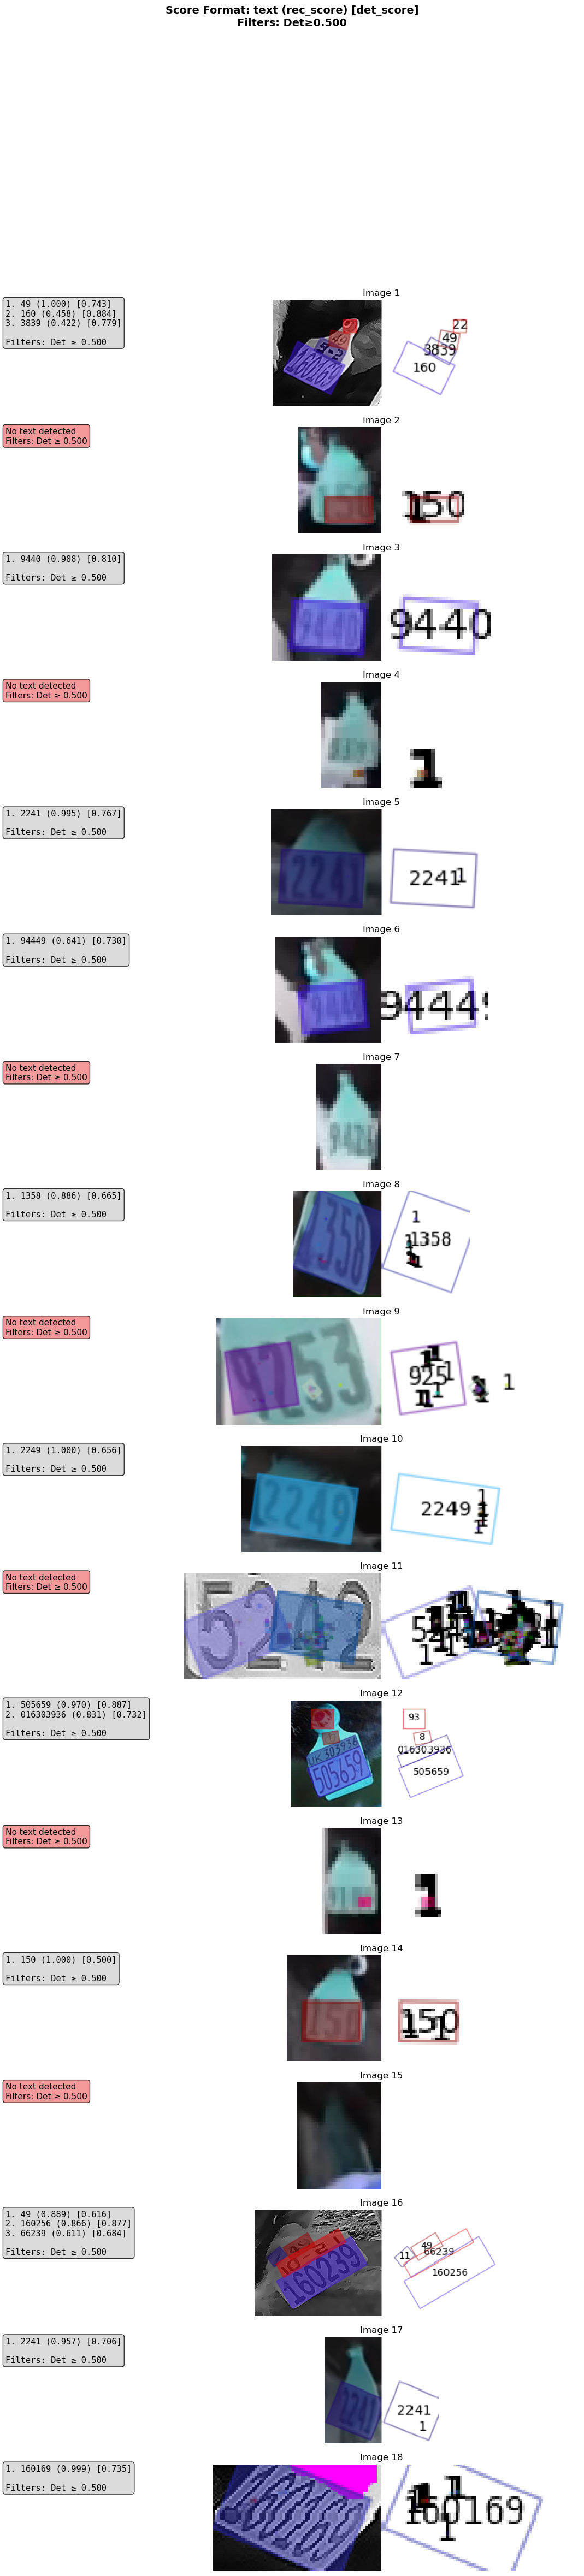

In [32]:
# Visualize end-to-end OCR results with confidence filtering

import math
import matplotlib.pyplot as plt
import numpy as np

# Confidence thresholds for filtering (None = no filtering)
TEXTDET_CONF = 0.5   # Detection confidence threshold
TEXTRECOG_CONF = None # Recognition confidence threshold

def filter_predictions(predictions, det_conf=None, rec_conf=None):
    """Filter predictions by detection and/or recognition confidence"""
    filtered_preds = []
    
    for pred in predictions:
        # Filter by detection confidence if specified
        if det_conf is not None and 'det_scores' in pred:
            det_mask = np.array(pred['det_scores']) >= det_conf
            if not det_mask.any():
                continue
            # Apply mask to all detection-related fields
            if 'det_polygons' in pred:
                pred['det_polygons'] = [poly for i, poly in enumerate(pred['det_polygons']) if det_mask[i]]
            if 'det_scores' in pred:
                pred['det_scores'] = [score for i, score in enumerate(pred['det_scores']) if det_mask[i]]
            # Apply mask to recognition fields (they correspond to detections)
            if 'rec_texts' in pred and len(pred['rec_texts']) == len(det_mask):
                pred['rec_texts'] = [text for i, text in enumerate(pred['rec_texts']) if det_mask[i]]
            if 'rec_scores' in pred and len(pred['rec_scores']) == len(det_mask):
                pred['rec_scores'] = [score for i, score in enumerate(pred['rec_scores']) if det_mask[i]]
        
        # Filter by recognition confidence if specified
        if rec_conf is not None and 'rec_scores' in pred:
            rec_mask = np.array(pred['rec_scores']) >= rec_conf
            if not rec_mask.any():
                continue
            # Apply mask to recognition fields
            if 'rec_texts' in pred:
                pred['rec_texts'] = [text for i, text in enumerate(pred['rec_texts']) if rec_mask[i]]
            if 'rec_scores' in pred:
                pred['rec_scores'] = [score for i, score in enumerate(pred['rec_scores']) if rec_mask[i]]
        
        filtered_preds.append(pred)
    
    return filtered_preds

# Process results with filtering and visualization
PLOT_ROWS = len(ocr_results)
fig, axes = plt.subplots(
    PLOT_ROWS, 2,
    figsize=(14, 3 * PLOT_ROWS),
    gridspec_kw={'width_ratios': [1, 3], 'wspace': 0.05}
)
if PLOT_ROWS == 1:
    axes = axes.reshape(1, -1)

# Add legend at the top of the figure
legend_parts = ['Score Format: text (rec_score) [det_score]']
if TEXTDET_CONF is not None or TEXTRECOG_CONF is not None:
    threshold_parts = []
    if TEXTDET_CONF is not None:
        threshold_parts.append(f'Det≥{TEXTDET_CONF:.3f}')
    if TEXTRECOG_CONF is not None:
        threshold_parts.append(f'Rec≥{TEXTRECOG_CONF:.3f}')
    legend_parts.append(f'Filters: {", ".join(threshold_parts)}')

fig.suptitle('\n'.join(legend_parts), fontsize=14, fontweight='bold', y=0.98)

for idx, result in enumerate(ocr_results):
    text_ax, img_ax = axes[idx]
    
    # Extract and convert visualization
    vis_bgr = result['visualization'][0]
    # vis_rgb = vis_bgr
    vis_rgb = vis_bgr[:, :, ::-1]  # Convert BGR to RGB (reverse only color channels)
    
    # Filter predictions
    filtered_predictions = filter_predictions(
        result['predictions'], 
        det_conf=TEXTDET_CONF, 
        rec_conf=TEXTRECOG_CONF
    )
    
    # Extract paired text-confidence data from filtered predictions
    text_score_pairs = []
    
    for pred in filtered_predictions:
        # Match recognition texts/scores with detection scores
        if 'rec_texts' in pred and 'rec_scores' in pred:
            rec_texts = pred['rec_texts']
            rec_scores = pred['rec_scores']
            det_scores = pred.get('det_scores', [])
            
            # Pair each recognition with its corresponding detection score
            for i, (text, rec_score) in enumerate(zip(rec_texts, rec_scores)):
                det_score = det_scores[i] if i < len(det_scores) else None
                text_score_pairs.append((text, rec_score, det_score))
    
    # Sort by recognition confidence (highest first) and limit to first 4
    text_score_pairs.sort(key=lambda x: x[1], reverse=True)
    top_texts = text_score_pairs[:4]
    
    # --- Image ---
    img_ax.imshow(vis_rgb)
    img_ax.axis('off')
    img_ax.set_title(f'Image {idx+1}', fontsize=12)
    
    # --- Recognition texts ---
    text_ax.axis('off')
    if top_texts:
        lines = []
        for i, (text, rec_score, det_score) in enumerate(top_texts, 1):
            if det_score is not None:
                lines.append(f'{i}. {text} ({rec_score:.3f}) [{det_score:.3f}]')
            else:
                lines.append(f'{i}. {text} ({rec_score:.3f})')
        
        # Add filtering info
        if TEXTDET_CONF is not None or TEXTRECOG_CONF is not None:
            lines.append('')
            filter_parts = []
            if TEXTDET_CONF is not None:
                filter_parts.append(f'Det ≥ {TEXTDET_CONF:.3f}')
            if TEXTRECOG_CONF is not None:
                filter_parts.append(f'Rec ≥ {TEXTRECOG_CONF:.3f}')
            lines.append(f'Filters: {", ".join(filter_parts)}')
        
        text_ax.text(
            0.0, 1.0, '\n'.join(lines),
            fontsize=11,
            va='top', ha='left',
            fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8)
        )
    else:
        filter_info = ""
        if TEXTDET_CONF is not None or TEXTRECOG_CONF is not None:
            filter_parts = []
            if TEXTDET_CONF is not None:
                filter_parts.append(f'Det ≥ {TEXTDET_CONF:.3f}')
            if TEXTRECOG_CONF is not None:
                filter_parts.append(f'Rec ≥ {TEXTRECOG_CONF:.3f}')
            filter_info = f'\nFilters: {", ".join(filter_parts)}'
        
        text_ax.text(0.0, 1.0, f'No text detected{filter_info}',
                     fontsize=11, va='top', ha='left',
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.8))

plt.tight_layout()
plt.show()

# Caveats

In [ ]:
# Init existing config in mmocr

# from mmengine.hub import get_config

# cfg = get_config('mmocr::textrecog/sar/sar_resnet31_parallel-decoder_5e_toy.py')
# cfg

In [ ]:
# # Init from arbitrary file

# from mmengine import Config
# %cd mmocr
# cfg = Config.fromfile('configs/textrecog/sar/sar_resnet31_parallel-decoder_5e_toy.py')